In [ ]:
import sys
sys.path.append("..")
sys.path.append("../..")

from importlib import reload

import numpy as np
from matplotlib import pyplot as plt

import original

import L96
import relax_punch

plt.rcParams["font.family"] = "serif"

reload(original)
system, system_no_sens = original.system, original.system_no_sens

# If True, use `system`, otherwise use `system_no_sens`.
# The former computes direct simulation sensitivity solutions while the latter
# does not.
# (In either case, when doing parameter updates we're using the asymptotic
# method, not the direct simulation method.)
include_sens = True

In [ ]:
def plot_ode_output(U_true, V_true, U_sim, V_sim):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # Plot true system
    ax = axs[0, 0]
    ax.plot(U_true)
    ax.set_ylabel("true system")
    ax.set_title("large systems")

    ax = axs[0, 1]
    ax.plot(V_true)
    ax.set_title("small systems")

    # Plot simulated system
    ax = axs[1, 0]
    ax.plot(U_sim)
    ax.set_ylabel("simulated system")
    ax.set_xlabel("i = 1, ..., I")

    ax = axs[1, 1]
    ax.plot(V_sim)
    ax.set_xlabel("i = 1, ..., I (each line is $v_{i, j}$ for all i)")

    fig.tight_layout()
    plt.show()

# Original implementation

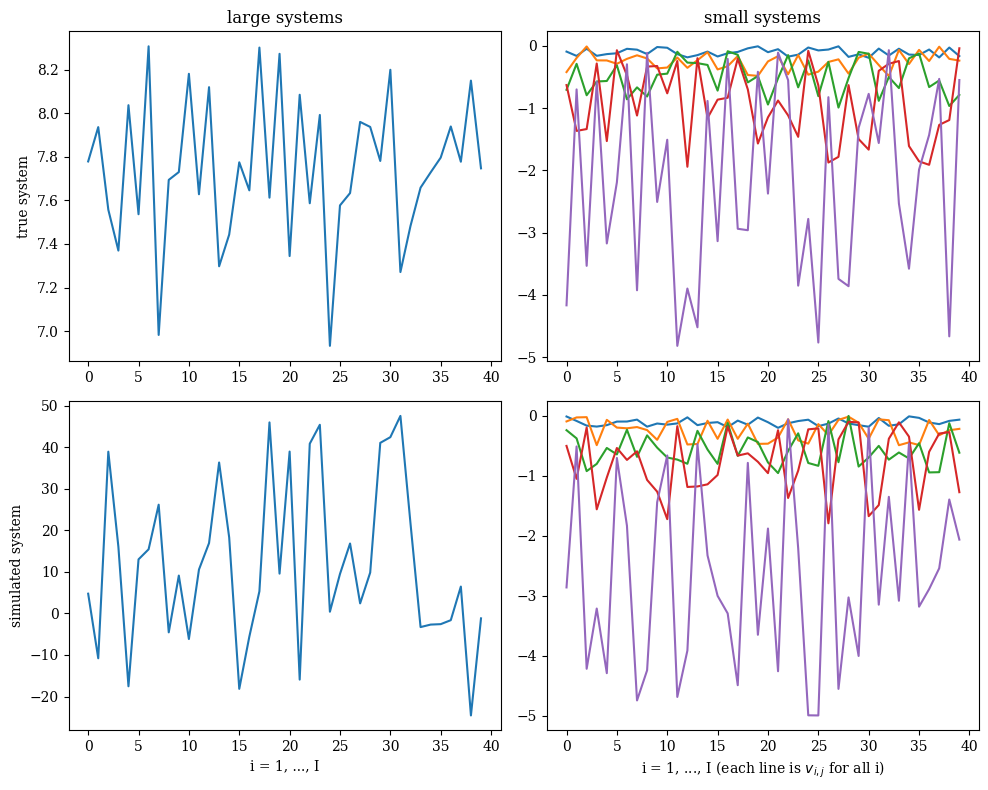

In [ ]:
# Set the dimensions of the system,
# I is the number of large scale systems
# and J the number of small scale terms per each large scale
I = 40
J = 5
size = I * (J + 1)

# The seed 42 leads to the two implementations yielding solutions with one spot
# of difference of magnitude about 1e-16.
# Other seeds lead to identical solutions.
rng = np.random.default_rng(42)

# Initial conditions
u0 = rng.uniform(size=size)
v0 = rng.uniform(size=size)
w10 = np.zeros(size)
w20 = np.zeros(size)
state0 = np.concatenate([u0, v0, w10, w20])

g = np.array([1e-2, 0.5])
F = 8.0  # forcing constant
d = np.array([0.2, 0.5, 1, 2, 5])  # dissipation coefficients for the v_{k,j}
mu = 50.0

if include_sens:
    out = system(0, state0, I, J, g, g, F, d, mu)
else:
    out = system_no_sens(0, state0, I, J, g, g, F, d, mu)

U_true = out[:I]
V_true = out[I : I * (J + 1)].reshape(I, J)

U_sim = out[I * (J + 1) : I * (J + 2)]
V_sim = out[I * (J + 2) : I * (2 * J + 2)].reshape(I, J)

plot_ode_output(U_true, V_true, U_sim, V_sim)

# My implementation

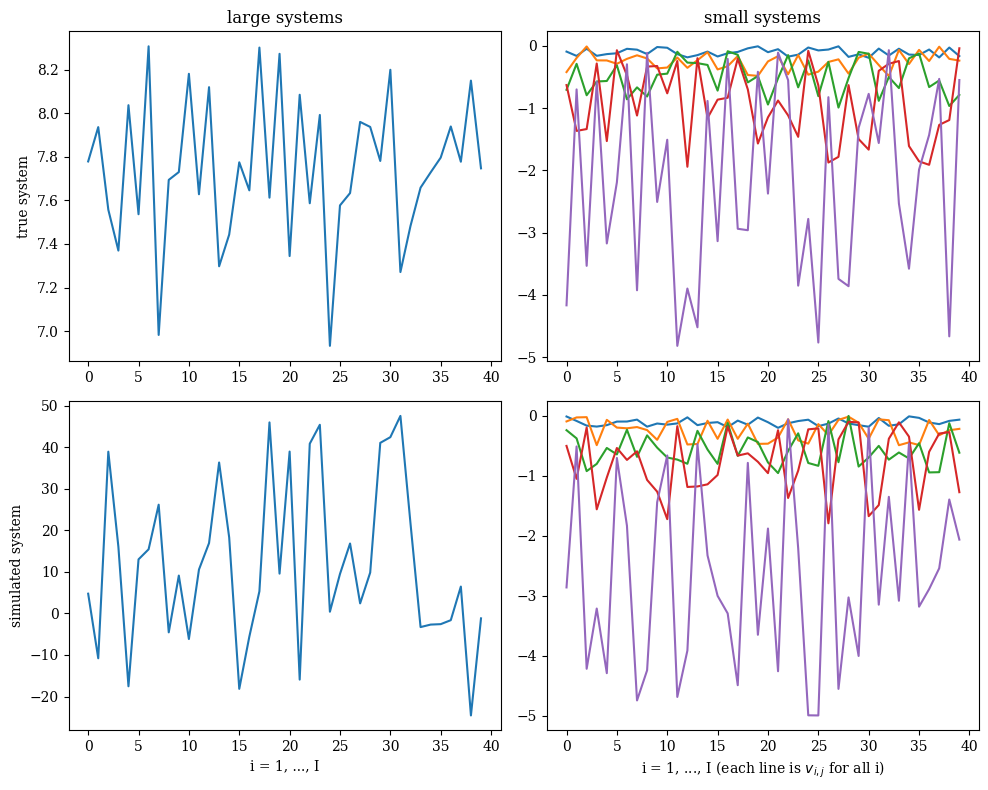

In [ ]:
# Dimensions
J_sim = J

# System evolution parameters
γ1, γ2 = g
c1, c2 = γ1, γ2

rp = relax_punch.RelaxPunch(I, J, J_sim, γ1, γ2, c1, c2, d, F, mu)

# Initial true state
U0 = u0[:I]
V0 = u0[I:]

# Initial simulation state
U0_sim = v0[:I]
V0_sim = v0[I:]

out_true = rp.system.ode_true(0, L96.together(U0, V0))
my_U_true, my_V_true = L96.apart(out_true, I, J)

out_sim = rp.system.ode_sim(0, L96.together(U0_sim, V0_sim), lambda _: U0)
my_U_sim, my_V_sim = L96.apart(out_sim, I, J)

plot_ode_output(my_U_true, my_V_true, my_U_sim, my_V_sim)

# Absolute difference between implementations

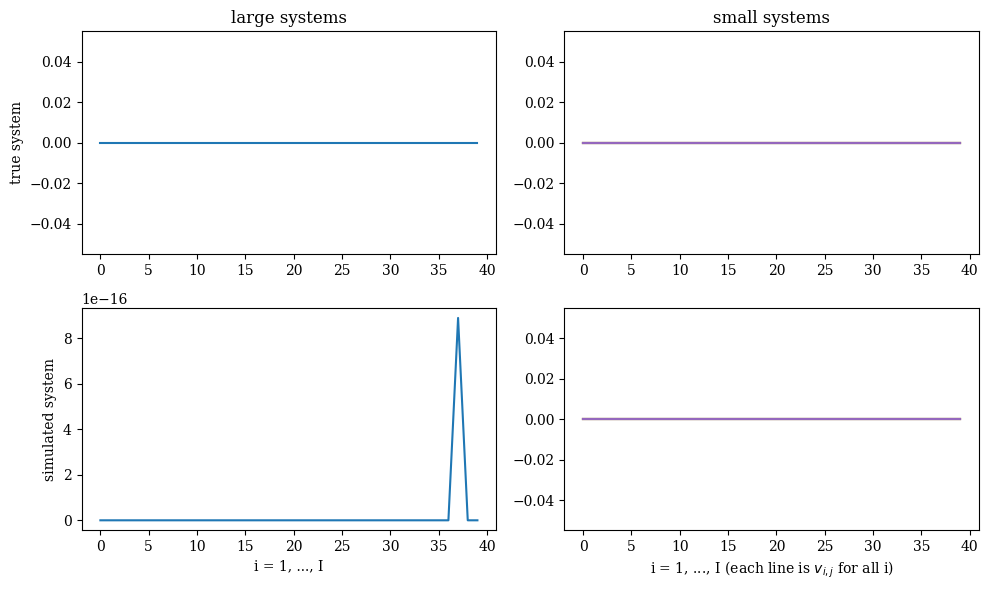

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

ax = axs[0, 0]
ax.plot(abs(U_true - my_U_true))
ax.set_ylabel("true system")
ax.set_title("large systems")

ax = axs[0, 1]
ax.plot(abs(V_true - my_V_true))
ax.set_title("small systems")

ax = axs[1, 0]
ax.plot(abs(U_sim - my_U_sim))
ax.set_ylabel("simulated system")
ax.set_xlabel("i = 1, ..., I")

ax = axs[1, 1]
ax.plot(abs(V_sim - my_V_sim))
ax.set_xlabel("i = 1, ..., I (each line is $v_{i, j}$ for all i)")

fig.tight_layout()
plt.show()